### Import libraries and set up random seed

In [197]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

random_seed = 1337
max_epochs = 50
fit_steps = 300
lrate = 0.001
use_drop = True
use_norm = True
np.random.seed(random_seed)

### Prepare our data

In [198]:
from keras.preprocessing.image import ImageDataGenerator

i=100

#will be used for validating our images
valid_generator = ImageDataGenerator(rescale = 1./255)

valid_gen = valid_generator.flow_from_directory('../data/data/valid',
                                      target_size = (64, 64),
                                      batch_size = 32,
                                      class_mode = 'binary',
                                      seed = random_seed)

#will be used only for our train data
test_generator = ImageDataGenerator(rescale = 1./255)

test_gen = test_generator.flow_from_directory('../data/data/test',
                                      target_size = (64, 64),
                                      batch_size = 32,
                                      class_mode = 'binary',
                                      seed = random_seed)

#generates new training images with geometric transformations
train_generator = ImageDataGenerator(rescale = 1./255,
                                     horizontal_flip = True,
                                     rotation_range = 20,
                                     zoom_range = 0.3,
                                     width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
                                     height_shift_range=0.1) #randomly shift images vertically

train_gen = train_generator.flow_from_directory('../data/data/train',
                                      target_size = (64, 64),
                                      batch_size = 64,
                                      class_mode = 'binary',
                                      seed = random_seed)

Found 2000 images belonging to 2 classes.
Found 2920 images belonging to 2 classes.
Found 9663 images belonging to 2 classes.


### Build and run our model

In [199]:
import datetime

from keras.layers import Flatten, Activation, Conv2D, MaxPool2D, AvgPool2D, Dense, Dropout, BatchNormalization, Input, MaxPooling2D, Flatten, Activation, Conv2D, AvgPool2D, Dense, Dropout, concatenate
from keras.optimizers import Adam, SGD
from keras.models import Sequential
import keras.backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from keras.models import model_from_json, Model

def build_tower(input_layer, features_nr, shape, tower_nr, 
                dropout=False, normalization=False, regularization="l2", dropout_ratio=0.25):
    #3x3 kernel tower
    tower = Conv2D(features_nr, (1,1), padding='same', activation='relu', 
                     kernel_regularizer=regularization, name='tower_%d_%dx%da'%(tower_nr, shape[0], shape[1]))(input_layer)
    tower = Conv2D(features_nr*2, shape, padding='same', activation='relu',
                     kernel_regularizer=regularization, name='tower_%d_%dx%db'%(tower_nr, shape[0], shape[1]))(tower)
    #condidional dropout/normalization
    if dropout:
        tower = Dropout(dropout_ratio, name='tower_%d_%dx%ddrop'%(tower_nr, shape[0], shape[1]))(tower)
    if normalization:
        tower = BatchNormalization(name='tower_%d_%dx%dnorm'%(tower_nr, shape[0], shape[1]))(tower)
        
    return tower

def build_simple_tower(input_layer, features_nr, shape, tower_nr, 
                dropout=False, normalization=False, regularization="l2", dropout_ratio=0.25):
    #3x3 kernel tower
    tower = Conv2D(features_nr, shape, padding='same', activation='relu',
                     kernel_regularizer=regularization, 
                   name='tower_simple_%d_%dx%db'%(tower_nr, shape[0], shape[1]))(input_layer)
    #condidional dropout/normalization
    if dropout:
        tower = Dropout(dropout_ratio, name='tower_%d_%dx%ddrop'%(tower_nr, shape[0], shape[1]))(tower)
    if normalization:
        tower = BatchNormalization(name='tower_%d_%dx%dnorm'%(tower_nr, shape[0], shape[1]))(tower)
        
    return tower

def build_tower_subsample(input_layer, features_nr, shape, tower_nr, 
                          dropout=False, normalization=False, regularization='l2', dropout_ratio=0.25):
    tower = build_tower(input_layer, features_nr, shape, tower_nr, 
                        dropout, normalization, regularization, dropout_ratio)
    pool = MaxPooling2D((2,2), padding='same', name='tower_%d_2x2subsample'%(tower_nr))(tower)

    return pool

def build_simple_tower_subsample(input_layer, features_nr, shape, tower_nr, 
                          dropout=False, normalization=False, regularization='l2', dropout_ratio=0.25):
    tower = build_simple_tower(input_layer, features_nr, shape, tower_nr, 
                        dropout, normalization, regularization, dropout_ratio)
    pool = MaxPooling2D((2,2), padding='same', name='tower_%d_2x2subsample'%(tower_nr))(tower)

    return pool

def build_dense(input_layer, neurons_nr, dense_nr, 
                dropout=False, normalization=False, regularization='l2', dropout_ratio=0.5):
    dense = Dense(neurons_nr, kernel_regularizer=regularization, 
                  name='dense_%d_%d'%(dense_nr, neurons_nr))(input_layer)
    
    if dropout:
        dense = Dropout(dropout_ratio, name='dense_%d_%ddrop'%(dense_nr, neurons_nr))(dense)
    if normalization:
        dense = BatchNormalization(name='dense_%d_%dnorm'%(dense_nr, neurons_nr))(dense)
    
    return dense

def build_inception_module(input_layer, features_nr, module_nr, 
                           dropout=False, normalization=False, regularization='l2', dropout_ratio=0.2):  
    tower_1 = build_tower(input_layer, features_nr, (3,3), module_nr, 
                          dropout, normalization, regularization, dropout_ratio)

    tower_2 = build_tower(input_layer, features_nr, (5,5), module_nr, 
                          dropout, normalization, regularization, dropout_ratio)

    #max pooling tower
    tower_3 = MaxPooling2D((3,3), strides=(1,1), padding='same', name='inception_%d_pool3x3a'%(module_nr))(input_layer)
    tower_3 = Conv2D(features_nr*2, (1,1), padding='same', activation='relu',
                    kernel_regularizer=regularization, name='inception_%d_pool3x3b'%(module_nr))(tower_3)
    if dropout:
        tower_3 = Dropout(dropout_ratio, name='inception_%d_pool3x3drop'%(module_nr))(tower_3)
    if normalization:
        tower_3 = BatchNormalization(name='inception_%d_pool3x3norm'%(module_nr))(tower_3)

    #concatenate and subsample towers
    output = concatenate([tower_1, tower_2, tower_3], axis = 3, name='inception_%d_concat'%(module_nr))

    pooled = MaxPooling2D((2,2), padding='same', name='inception_%d_2x2subsample'%(module_nr))(output)
    
    return pooled

i=datetime.datetime.now().strftime("%I:%M%p_%B-%d-%Y")

K.clear_session()

a = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')#will stop the model if val_loss does not improve for 2 consecutive epochs
b = ModelCheckpoint(monitor='val_loss', filepath='../models/man-woman-occam-'+str(i)+'.hdf5', verbose=1, save_best_only=True)#save model weights after each epoch if val_loss improves
c = TensorBoard(log_dir='./man-woman-logs/'+str(i),
                write_grads=True,
                write_graph=True,
                write_images=True,
                batch_size=128)#saves a log file for tensorboard; remember to save different runs to different subdirectories

#we'll use this instead of decay
d = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)

callbacks=[a,b,c,d]

#------------model definition-------------------

input_img = Input(shape = (64, 64, 3), name='input')

#conv_1 = Conv2D(1, (1,1), padding='same', activation='relu', 
               # kernel_regularizer = regularization, name='conv_64x64x1_inception_in')(input_img)

#hopefully this will learn a good internal representation of the image channels
#conv_1 = Conv2D(1, (1,1), padding='same', activation='relu', 
                #kernel_regularizer = regularization, name='conv_64x64x1_inception_in')(input_img)

inception_1 = build_inception_module(input_img, 3, 1, True, use_norm)

inception_2 = build_inception_module(inception_1, 36, 2, True, use_norm)

tower_3 = build_simple_tower(inception_2, 144, (3,3),  3, False, use_norm)
tower_4 = build_simple_tower_subsample(tower_3, 144, (3,3), 4, False, use_norm)

tower_5 = build_simple_tower(tower_4, 288, (3,3),  5, False, use_norm)
tower_6 = build_simple_tower_subsample(tower_5, 288, (3,3), 6, False, use_norm)

#model top

flat = Flatten()(tower_6)

dense_5 = build_dense(flat, 128, 1, True, use_norm)

dense_6 = build_dense(dense_5, 64, 2, True, use_norm)

out = Dense(1, activation='sigmoid')(dense_6)

model = Model(inputs = input_img, outputs = out)

#-----------------------------------------------

model.compile(loss='binary_crossentropy',
              optimizer=Adam(lrate),
              metrics=['accuracy'])

model.summary()

model_json = model.to_json()
with open("../models/man-woman-occam-"+str(i)+".json", "w") as json_file:
    json_file.write(model_json)

print("Saved model to" + "../models/man-woman-"+str(i)+".json")



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
tower_1_3x3a (Conv2D)           (None, 64, 64, 3)    12          input[0][0]                      
__________________________________________________________________________________________________
tower_1_5x5a (Conv2D)           (None, 64, 64, 3)    12          input[0][0]                      
__________________________________________________________________________________________________
inception_1_pool3x3a (MaxPoolin (None, 64, 64, 3)    0           input[0][0]                      
__________________________________________________________________________________________________
tower_1_3x

In [201]:
model.fit_generator(train_gen, 
                    epochs=max_epochs+50, 
                    initial_epoch = 50,
                    steps_per_epoch=fit_steps,
                    verbose=1, 
                    callbacks=callbacks, 
                    validation_data=valid_gen)

Epoch 51/100
300/300 [==============================] - 72s 239ms/step - loss: 0.3205 - acc: 0.8817 - val_loss: 0.3459 - val_acc: 0.8570

Epoch 00051: val_loss improved from 0.34727 to 0.34587, saving model to ../models/man-woman-occam-06:02PM_June-24-2018.hdf5
Epoch 52/100
300/300 [==============================] - 68s 227ms/step - loss: 0.3183 - acc: 0.8831 - val_loss: 0.3504 - val_acc: 0.8525

Epoch 00052: val_loss did not improve from 0.34587
Epoch 53/100
300/300 [==============================] - 68s 227ms/step - loss: 0.3143 - acc: 0.8858 - val_loss: 0.3507 - val_acc: 0.8545

Epoch 00053: val_loss did not improve from 0.34587
Epoch 54/100
300/300 [==============================] - 68s 226ms/step - loss: 0.3120 - acc: 0.8867 - val_loss: 0.3502 - val_acc: 0.8560

Epoch 00054: val_loss did not improve from 0.34587
Epoch 55/100
300/300 [==============================] - 68s 226ms/step - loss: 0.3097 - acc: 0.8898 - val_loss: 0.3422 - val_acc: 0.8575

Epoch 00055: val_loss improved fr

In [202]:
results = model.evaluate_generator(test_gen)

model.load_weights("../models/man-woman-occam-06:02PM_June-24-2018.hdf5")

print("Accuracy {0:.2f} %".format(results[1]*100))

Accuracy 86.37 %


|Model architecture | Optimizer | Train batch / steps | Train images | Stop epoch | Test accuracy |
|------------- |---|-------------|----|
|2 x inception(w dr) 2 x (conv(144ft)+maxpool) flt 2 x dense (w dr) act \[w batch normalization\]|Adam(0.001)|64/300|Normalized color + augmentation|41|86.47 %
|2 x inception(w dr) (conv(144ft)+maxpool) (conv(288ft)+maxpool) flt 2 x dense (w dr) \[w batch normalization\]|Adam(0.001)|64/300|Normalized color + augmentation|65|86.37 %

In [129]:
classes = model.predict_generator(test_gen)

In [130]:
classes = classes > 0.5

,0
count,2920
unique,2
top,False
freq,1502


In [203]:
plt.figure(figsize=(12, 12))

mislabeled_img = []
mislabeled_orig = []
mislabeled_labels = []

for _ in range(len(test_gen)):
    images, labels = test_gen.next()
    predictions = model.predict(images)
    for i in range(len(predictions)):
        if abs(predictions[i]-labels[i]) >= 0.5:
            mislabeled_img.append(images[i])
            mislabeled_orig.append(labels[i])
            mislabeled_labels.append(predictions[i])

<Figure size 864x864 with 0 Axes>

In [204]:
len(mislabeled_img)

401

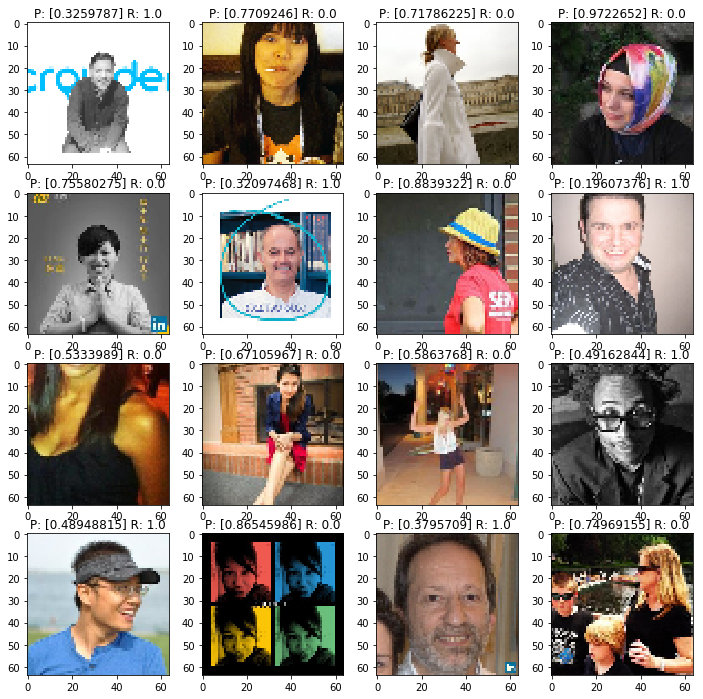

In [205]:
plt.figure(figsize=(12, 12))
for i in range(16):
    plt.subplot(4, 4, i+1)
    s = 'P: '+str(mislabeled_labels[i]) +' R: ' +str(mislabeled_orig[i])
    plt.gca().set_title(s)
    plt.imshow(mislabeled_img[i])